In [230]:
import os

import seaborn as sns

import pandas as pd
import numpy as np

import cv2
import imageio

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

cuts_folder = "../../data/cuts/"
analysis_folder = "../../data/analysis/variation_hist_metrics"

# Load Analysis Data

In [2]:
analysis_files = [f for f in os.listdir(analysis_folder) if os.path.isfile(os.path.join(analysis_folder, f))]

In [3]:
analysis_files
frame_wise = [f for f in analysis_files if 'byFrame' in f]
cut_wise = [f for f in analysis_files if 'byCut' in f]

In [169]:
frame_wise_df = []
for f in frame_wise:
    this_df = pd.read_csv(os.path.join(analysis_folder, f), index_col=0)
    youtube_key = f.split("_by")[0]
    cuts = np.load(os.path.join(cuts_folder, f"{youtube_key}_cuts.npy"))
    this_df['is_cut'] = (this_df.index+1).isin(cuts)
    frame_wise_df.append(this_df)

In [170]:
frame_wise_df = pd.concat(
    frame_wise_df,
    keys=[f.split("_by")[0] for f in frame_wise]
)
frame_wise_df.index = frame_wise_df.index.rename(['yt_id', 'frame'])

/home/bmild/anaconda2/envs/comp-color/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [171]:
frame_wise_df

hist_bhattacharyya  hist_correlation  hist_intersection  \
yt_id       frame                                                            
aNQqoExfQsg 0                7.824046          0.975650           0.000400   
            1                6.904790          0.653459           0.000759   
            2                4.511140          0.597374           0.007696   
            3                3.547602          0.773592           0.023360   
            4                3.092202          0.862521           0.031763   
...                               ...               ...                ...   
0FIm5ATyAY0 3332             7.824046          1.000000           0.000400   
            3333             7.824046          1.000000           0.000400   
            3334             7.824046          1.000000           0.000400   
            3335             7.824046          1.000000           0.000400   
            3336             7.824046          1.000000           0.000400   

                   is_cut  
yt_id       frame          
aNQqoExfQsg 0       False  
            1       False  
            2       False  
            3       False  
            4       False  
...                   ...  
0FIm5ATyAY0 3332    False  
            3333    False  
            3334    False  
            3335    False  
            3336    False  

[6524862 rows x 4 columns]

In [138]:
cut_wise_df = [pd.read_csv(os.path.join(analysis_folder, f), index_col=0, dtype='float64') for f in cut_wise]
cut_wise_df = pd.concat(
    cut_wise_df,
    keys=[f.split("_by")[0] for f in cut_wise]
)
cut_wise_df.index = cut_wise_df.index.rename(['yt_id', 'cut'])

/home/bmild/anaconda2/envs/comp-color/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [139]:
cut_wise_df

hist_bhattacharyya  hist_correlation  hist_intersection
yt_id       cut                                                          
Yj4GeCk5SBk 0.0                  NaN               NaN                NaN
            1.0             1.294350          0.277489           0.143556
            2.0             0.720729          0.165521           0.252096
            3.0            -0.735870          0.749388           1.560219
            4.0            -1.482468          0.763989           1.729768
...                              ...               ...                ...
-PAGAOrv6UI 95.0           -0.409586          0.446245           0.913462
            96.0           -0.583252          0.874655           1.362149
            97.0           -0.036647          0.757952           0.712722
            98.0            0.242762          0.543643           0.506366
            99.0            0.128249          0.453401           0.527836

[157446 rows x 3 columns]

# Prep metadata structures

In [93]:
import json

In [94]:
with open('../data/movie_details.json', 'r') as f:
    movie_details = json.load(f)

In [95]:
movie_details['278']['genres']

[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name': 'Crime'}]

In [96]:
tmdb_to_genres = {int(k): [d['name'] for d in v['genres']] for k, v in movie_details.items()}
tmdb_to_genres = pd.Series(tmdb_to_genres)
tmdb_to_genres.index.name = 'tmdb_id'
tmdb_to_genres = pd.DataFrame(tmdb_to_genres)
tmdb_to_genres.columns = ['genres']
tmdb_to_genres.index.dtype

dtype('int64')

In [97]:
# Filter out Animated films for the rest of analyses, to focus on Live Action films
tmdb_to_genres = tmdb_to_genres[~tmdb_to_genres['genres'].apply(lambda gs: 'Animation' in gs)]

In [98]:
tmdb_to_genres

,genres
tmdb_id,
278,"[Drama, Crime]"
238,"[Drama, Crime]"
424,"[Drama, History, War]"
240,"[Drama, Crime]"
497,"[Fantasy, Drama, Crime]"
...,...
71676,"[Action, Fantasy, Thriller]"
10196,"[Action, Adventure, Family, Fantasy]"
166424,"[Action, Adventure, Science Fiction]"


In [99]:
tmdb_to_yt = pd.read_csv("../data/trailers.csv", index_col=1)[['trailer_youtube_key']]
tmdb_to_yt.index = tmdb_to_yt.index.map(int)
tmdb_to_yt = tmdb_to_yt.rename(columns={'trailer_youtube_key': 'yt_id'})

In [100]:
tmdb_to_yt

,yt_id
tmdb_id,
278,K_tLp7T6U1c
278,uMwECVb1q54
278,BXUEUwwgIyU
278,EsHlXpbMPOc
238,_IqFJLdV13o
...,...
166424,_flR9_6msik
166424,_rRoD28-WgU
166424,AAgnQdiZFsQ


In [101]:
yt_to_tmdb = pd.Series(tmdb_to_yt.index.values, index=tmdb_to_yt['yt_id'])

In [102]:
yt_to_tmdb

yt_id
K_tLp7T6U1c       278
uMwECVb1q54       278
BXUEUwwgIyU       278
EsHlXpbMPOc       278
_IqFJLdV13o       238
                ...  
_flR9_6msik    166424
_rRoD28-WgU    166424
AAgnQdiZFsQ    166424
YH9ju47g4x0       415
gvxNaSIB_WI    351460
Length: 2003, dtype: int64

In [103]:
yt_genres_df = tmdb_to_yt.merge(tmdb_to_genres, left_index=True, right_index=True)
yt_genres_df = yt_genres_df.rename(columns={'trailer_youtube_key': 'yt_id'})

In [104]:
yt_genres_df

,yt_id,genres
tmdb_id,,
11,vZ734NWnAHA,"[Adventure, Action, Science Fiction]"
11,i-vsILeJ8_8,"[Adventure, Action, Science Fiction]"
11,XHk5kCIiGoM,"[Adventure, Action, Science Fiction]"
13,bLvqoHBptjg,"[Comedy, Drama, Romance]"
14,3ycmmJ6rxA8,[Drama]
...,...,...
493922,V6wWKNij_1M,"[Horror, Mystery, Thriller]"
493922,MJNR58zaStE,"[Horror, Mystery, Thriller]"
504172,N_QksSzK7sI,"[Crime, Drama, Thriller]"


In [105]:
yt_to_genres = pd.Series(yt_genres_df['genres'].values, index=yt_genres_df['yt_id'].values)
yt_to_genres = pd.DataFrame({'genres': yt_to_genres})
yt_to_genres.index.name = 'yt_id'


In [106]:
yt_to_genres

,genres
yt_id,
vZ734NWnAHA,"[Adventure, Action, Science Fiction]"
i-vsILeJ8_8,"[Adventure, Action, Science Fiction]"
XHk5kCIiGoM,"[Adventure, Action, Science Fiction]"
bLvqoHBptjg,"[Comedy, Drama, Romance]"
3ycmmJ6rxA8,[Drama]
...,...
V6wWKNij_1M,"[Horror, Mystery, Thriller]"
MJNR58zaStE,"[Horror, Mystery, Thriller]"
N_QksSzK7sI,"[Crime, Drama, Thriller]"


In [126]:
def df_list_to_rows(df, lst_col):
    df = df.reset_index()
    r = pd.DataFrame({
      col:np.repeat(df[col].values, df[lst_col].str.len())
      for col in df.columns.drop(lst_col)}
    ).assign(**{lst_col:np.concatenate(df[lst_col].values)})[df.columns]
    return r

In [127]:
df_list_to_rows(yt_genres_df, 'genres')

,tmdb_id,yt_id,genres
0,11,vZ734NWnAHA,Adventure
1,11,vZ734NWnAHA,Action
2,11,vZ734NWnAHA,Science Fiction
3,11,i-vsILeJ8_8,Adventure
4,11,i-vsILeJ8_8,Action
...,...,...,...
4915,569547,XM0xWpBYlNM,Science Fiction
4916,569547,XM0xWpBYlNM,Mystery
4917,569547,XM0xWpBYlNM,Drama
4918,569547,XM0xWpBYlNM,Thriller


In [133]:
ytId_by_genre = df_list_to_rows(yt_genres_df, 'genres')
#ytId_by_genre

In [134]:
ytId_by_genre = ytId_by_genre.set_index(r['genres'])[['yt_id']]
ytId_by_genre.index.unique()

Index(['Adventure', 'Action', 'Science Fiction', 'Comedy', 'Drama', 'Romance',
       'Mystery', 'Fantasy', 'Thriller', 'Crime', 'War', 'Western', 'Music',
       'Family', 'History', 'Horror', 'TV Movie'],
      dtype='object', name='genres')

In [135]:
ytId_by_genre

,yt_id
genres,
Adventure,vZ734NWnAHA
Action,vZ734NWnAHA
Science Fiction,vZ734NWnAHA
Adventure,i-vsILeJ8_8
Action,i-vsILeJ8_8
...,...
Science Fiction,XM0xWpBYlNM
Mystery,XM0xWpBYlNM
Drama,XM0xWpBYlNM


# Subsequent Cut Analysis

In [140]:
cut_wise_df_with_genre = pd.merge(yt_to_genres.reset_index(),
      cut_wise_df.reset_index(),
      on=['yt_id'],
      how='inner'
     ).set_index(['yt_id','cut'])
cut_wise_df_with_genre

genres  \
yt_id       cut                                                       
vZ734NWnAHA 0.0                [Adventure, Action, Science Fiction]   
            1.0                [Adventure, Action, Science Fiction]   
            2.0                [Adventure, Action, Science Fiction]   
            3.0                [Adventure, Action, Science Fiction]   
            4.0                [Adventure, Action, Science Fiction]   
...                                                             ...   
XM0xWpBYlNM 64.0  [Science Fiction, Mystery, Drama, Thriller, TV...   
            65.0  [Science Fiction, Mystery, Drama, Thriller, TV...   
            66.0  [Science Fiction, Mystery, Drama, Thriller, TV...   
            67.0  [Science Fiction, Mystery, Drama, Thriller, TV...   
            68.0  [Science Fiction, Mystery, Drama, Thriller, TV...   

                  hist_bhattacharyya  hist_correlation  hist_intersection  
yt_id       cut                                                            
vZ734NWnAHA 0.0                  NaN               NaN                NaN  
            1.0            -0.032686          0.683988           0.694034  
            2.0            -0.279689          0.684759           0.788210  
            3.0            -0.789772          0.786797           1.589262  
            4.0            -0.377616          0.692211           0.920815  
...                              ...               ...                ...  
XM0xWpBYlNM 64.0            2.401935          0.672483           0.071760  
            65.0            1.600354          0.511766           0.107908  
            66.0            0.566713          0.505900           0.398318  
            67.0           -0.214059          0.656937           0.698335  
            68.0           -0.205536          0.180054           0.594387  

[138433 rows x 4 columns]

In [174]:
subsequent_cut_df = df_list_to_rows(cut_wise_df_with_genre, 'genres')
subsequent_cut_df

NameError: name 'subsequent_frame_df' is not defined

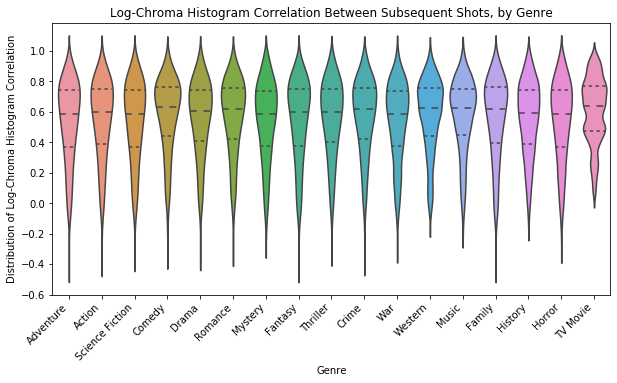

In [201]:
fig, ax = plt.subplots(figsize=(10, 5))

ax = sns.violinplot(
    ax=ax,
    x='genres',
    y='hist_correlation',
    data=subsequent_cut_df,
    inner="quartile",
    bw=.2
)
ax.set(title='Log-Chroma Histogram Correlation Between Subsequent Shots, by Genre', xlabel='Genre', ylabel='Distribution of Log-Chroma Histogram Correlation')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
fig.savefig("analysis_output/subs_cut.png", bbox_extra_artists=(ax.yaxis,), dpi=500, bbox_inches='tight')

# Subsequent Frame Analysis

In [172]:
frame_wise_df

hist_bhattacharyya  hist_correlation  hist_intersection  \
yt_id       frame                                                            
aNQqoExfQsg 0                7.824046          0.975650           0.000400   
            1                6.904790          0.653459           0.000759   
            2                4.511140          0.597374           0.007696   
            3                3.547602          0.773592           0.023360   
            4                3.092202          0.862521           0.031763   
...                               ...               ...                ...   
0FIm5ATyAY0 3332             7.824046          1.000000           0.000400   
            3333             7.824046          1.000000           0.000400   
            3334             7.824046          1.000000           0.000400   
            3335             7.824046          1.000000           0.000400   
            3336             7.824046          1.000000           0.000400   

                   is_cut  
yt_id       frame          
aNQqoExfQsg 0       False  
            1       False  
            2       False  
            3       False  
            4       False  
...                   ...  
0FIm5ATyAY0 3332    False  
            3333    False  
            3334    False  
            3335    False  
            3336    False  

[6524862 rows x 4 columns]

In [173]:
frame_wise_df = pd.merge(yt_to_genres.reset_index(),
      frame_wise_df.reset_index(),
      on=['yt_id'],
      how='inner'
     ).set_index(['yt_id','frame'])
frame_wise_df

genres  \
yt_id       frame                                                      
vZ734NWnAHA 0                   [Adventure, Action, Science Fiction]   
            1                   [Adventure, Action, Science Fiction]   
            2                   [Adventure, Action, Science Fiction]   
            3                   [Adventure, Action, Science Fiction]   
            4                   [Adventure, Action, Science Fiction]   
...                                                              ...   
XM0xWpBYlNM 2439   [Science Fiction, Mystery, Drama, Thriller, TV...   
            2440   [Science Fiction, Mystery, Drama, Thriller, TV...   
            2441   [Science Fiction, Mystery, Drama, Thriller, TV...   
            2442   [Science Fiction, Mystery, Drama, Thriller, TV...   
            2443   [Science Fiction, Mystery, Drama, Thriller, TV...   

                   hist_bhattacharyya  hist_correlation  hist_intersection  \
yt_id       frame                                                            
vZ734NWnAHA 0                7.824046          0.550185           0.000400   
            1                4.095690          0.998614           0.016311   
            2                4.074472          0.982242           0.015642   
            3                3.997364          0.993737           0.017535   
            4                3.981220          0.987689           0.017457   
...                               ...               ...                ...   
XM0xWpBYlNM 2439             6.072930          1.000000           0.002304   
            2440             6.072930          1.000000           0.002304   
            2441             6.072930          1.000000           0.002304   
            2442             6.072930          1.000000           0.002304   
            2443             6.072930          1.000000           0.002304   

                   is_cut  
yt_id       frame          
vZ734NWnAHA 0       False  
            1       False  
            2       False  
            3       False  
            4        True  
...                   ...  
XM0xWpBYlNM 2439    False  
            2440    False  
            2441    False  
            2442    False  
            2443    False  

[5649721 rows x 5 columns]

In [175]:
subsequent_frame_df = df_list_to_rows(frame_wise_df, 'genres')
subsequent_frame_df

,yt_id,frame,genres,hist_bhattacharyya,hist_correlation,hist_intersection,is_cut
0,vZ734NWnAHA,0,Adventure,7.824046,0.550185,0.000400,False
1,vZ734NWnAHA,0,Action,7.824046,0.550185,0.000400,False
2,vZ734NWnAHA,0,Science Fiction,7.824046,0.550185,0.000400,False
3,vZ734NWnAHA,1,Adventure,4.095690,0.998614,0.016311,False
4,vZ734NWnAHA,1,Action,4.095690,0.998614,0.016311,False
...,...,...,...,...,...,...,...
16019228,XM0xWpBYlNM,2443,Science Fiction,6.072930,1.000000,0.002304,False
16019229,XM0xWpBYlNM,2443,Mystery,6.072930,1.000000,0.002304,False
16019230,XM0xWpBYlNM,2443,Drama,6.072930,1.000000,0.002304,False
16019231,XM0xWpBYlNM,2443,Thriller,6.072930,1.000000,0.002304,False


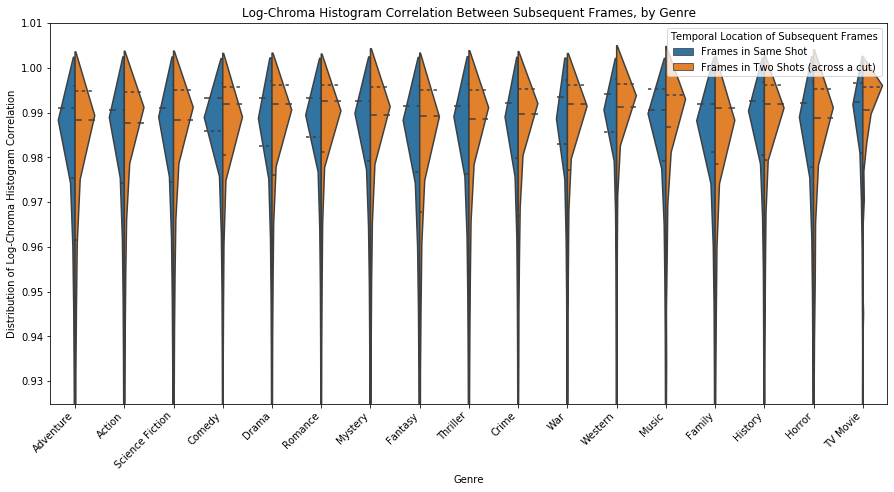

In [207]:
fig, ax = plt.subplots(figsize=(15, 7))

ax = sns.violinplot(
    ax=ax,
    x='genres',
    y='hist_correlation',
    hue='is_cut',
    data=subsequent_frame_df,#.head(100000),
    inner="quartile",
    split=True,
    bw=.01,
    legend_out=True
)

# Legend 
leg = ax.axes.get_legend()
leg.set_title('Temporal Location of Subsequent Frames')
new_labels = ['Frames in Same Shot', 'Frames in Two Shots (across a cut)']
for t, l in zip(leg.texts, new_labels): t.set_text(l)
    
ax.set(
    title='Log-Chroma Histogram Correlation Between Subsequent Frames, by Genre',
    xlabel='Genre',
    ylabel='Distribution of Log-Chroma Histogram Correlation',
    ylim=(0.925, 1.01)
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

# Axis Labels
fig.savefig("analysis_output/subs_frame.png", bbox_extra_artists=(ax.yaxis,), dpi=500, bbox_inches='tight')

# Log-Chroma Color Variation between all shots in each trailer

In [208]:
def chroma_hist_to_rgb_vis(hist, bin_res):
    edges = np.array([
        np.linspace(-1, 1, bin_res[0]+1),
        np.linspace(-1, 1, bin_res[1]+1)
    ])
    # Hist to Image
    hist_vis = np.zeros((hist.shape[0], hist.shape[1], 3))
    # green
    hist_vis[:, :, 1] = hist
    # red
    hist_vis[:, :, 0] = hist / np.exp(edges[0][:-1])[:, None]
    # blue
    hist_vis[:, :, 2] = hist / np.exp(edges[1][:-1])[None, :]

    hist_vis = np.clip(hist_vis,0,1)
    hist_vis *= 255
    hist_vis = np.uint8(hist_vis)
    return hist_vis

## All Trailers

In [233]:
stddev_hist_folder = "../../data/analysis/temporal_hist_std"
stddev_hist_dirs = [
    os.path.join(stddev_hist_folder, f)
    for f 
    in os.listdir(stddev_hist_folder)
    if f[-4:] == '.npy'
]
print(len(stddev_hist_dirs))

814


In [236]:
def hist_dirs_to_mean_img(dirs, omit_grey=True):
    if not dirs:
        return
    stddev_hists = [np.load(f) for f in dirs]
    stddev_hists = np.stack(stddev_hists)
    stddev_hists_mean = np.mean(stddev_hists, axis=0)
    if omit_grey:
        stddev_hists_mean[
            int(stddev_hists_mean.shape[0]/2)-1,
            int(stddev_hists_mean.shape[1]/2)-1
        ] = 0
    stddev_hists_mean_norm = stddev_hists_mean - stddev_hists_mean.min()
    stddev_hists_mean_norm = stddev_hists_mean_norm / stddev_hists_mean_norm.max()
    stddev_hists_mean_img = chroma_hist_to_rgb_vis(stddev_hists_mean_norm, (50, 50))
    return stddev_hists_mean_img

def save_and_resize(path, img):
    img_r = cv2.resize(img, (1000, 1000), interpolation=cv2.INTER_NEAREST)
    return img_r, cv2.imwrite(path, img_r)

In [237]:
stddev_hists_mean_img = hist_dirs_to_mean_img(stddev_hist_dirs, omit_grey=False)

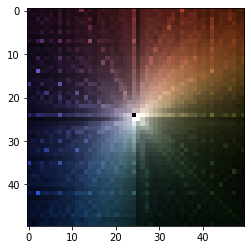

In [238]:
plt.imshow(stddev_hists_mean_img)

In [229]:
save_and_resize("analysis_output/hist_stddev_all.png", stddev_hists_mean_img)

(array([[[ 9,  3,  9],
         [ 9,  3,  9],
         [ 9,  3,  9],
         ...,
         [25,  9,  3],
         [25,  9,  3],
         [25,  9,  3]],
 
        [[ 9,  3,  9],
         [ 9,  3,  9],
         [ 9,  3,  9],
         ...,
         [25,  9,  3],
         [25,  9,  3],
         [25,  9,  3]],
 
        [[ 9,  3,  9],
         [ 9,  3,  9],
         [ 9,  3,  9],
         ...,
         [25,  9,  3],
         [25,  9,  3],
         [25,  9,  3]],
 
        ...,
 
        [[ 1,  4, 13],
         [ 1,  4, 13],
         [ 1,  4, 13],
         ...,
         [ 3,  8,  3],
         [ 3,  8,  3],
         [ 3,  8,  3]],
 
        [[ 1,  4, 13],
         [ 1,  4, 13],
         [ 1,  4, 13],
         ...,
         [ 3,  8,  3],
         [ 3,  8,  3],
         [ 3,  8,  3]],
 
        [[ 1,  4, 13],
         [ 1,  4, 13],
         [ 1,  4, 13],
         ...,
         [ 3,  8,  3],
         [ 3,  8,  3],
         [ 3,  8,  3]]], dtype=uint8), True)

## By Genre

In [239]:
imgs = []
for genre in ytId_by_genre.index.unique():
    this_genre_ids = set(ytId_by_genre.loc[genre]['yt_id'].values)
    this_genre_dirs = [
        f
        for f
        in stddev_hist_dirs
        if os.path.basename(f).split("_")[0] in this_genre_ids
    ]
    total_num_trailers = len(this_genre_ids)
    print(f"Processing genre: {genre} - {len(this_genre_dirs)}/{total_num_trailers}")
    this_genre_stddev_hists_mean_img = hist_dirs_to_mean_img(this_genre_dirs)
    if this_genre_stddev_hists_mean_img is not None:
        img_r, _ = save_and_resize(f"analysis_output/hist_stddev_{genre}.png", this_genre_stddev_hists_mean_img)
        imgs.append(img_r)
print(imgs[0].shape)
imageio.mimwrite('./hist_stddev_genres.gif', imgs, fps=1)

Processing genre: Adventure - 205/615
Processing genre: Action - 274/817
Processing genre: Science Fiction - 156/476
Processing genre: Comedy - 126/370
Processing genre: Drama - 197/644
Processing genre: Romance - 72/206
Processing genre: Mystery - 46/169
Processing genre: Fantasy - 127/341
Processing genre: Thriller - 166/537
Processing genre: Crime - 83/274
Processing genre: War - 20/61
Processing genre: Western - 9/20
Processing genre: Music - 9/27
Processing genre: Family - 36/119
Processing genre: History - 15/63
Processing genre: Horror - 50/178
Processing genre: TV Movie - 0/2
(1000, 1000, 3)


In [218]:
imageio.help('gif')

GIF-PIL - Static and animated gif (Pillow)

    A format for reading and writing static and animated GIF, based
    on Pillow.
    
    Images read with this format are always RGBA. Currently,
    the alpha channel is ignored when saving RGB images with this
    format.
    
    Parameters for reading
    ----------------------
    None
    
    Parameters for saving
    ---------------------
    loop : int
        The number of iterations. Default 0 (meaning loop indefinitely).
    duration : {float, list}
        The duration (in seconds) of each frame. Either specify one value
        that is used for all frames, or one value for each frame.
        Note that in the GIF format the duration/delay is expressed in
        hundredths of a second, which limits the precision of the duration.
    fps : float
        The number of frames per second. If duration is not given, the
        duration for each frame is set to 1/fps. Default 10.
    palettesize : int
        The number of colors t

### Casual Photos

In [240]:
stddev_hist_casual_folder = "../../data/casual/analysis/temporal_hist_std"
stddev_hist_casual_folder = [
    os.path.join(stddev_hist_casual_folder, f)
    for f 
    in os.listdir(stddev_hist_casual_folder)
    if f[-4:] == '.npy'
]
print(len(stddev_hist_casual_folder))

18


In [241]:
stddev_hists_casual_mean_img = hist_dirs_to_mean_img(stddev_hist_dirs, omit_grey=False)

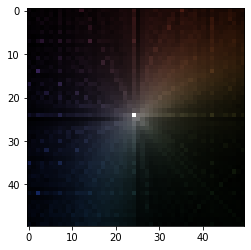

In [242]:
plt.imshow(stddev_hists_casual_mean_img)

In [243]:
save_and_resize("analysis_output/stddev_hists_casual_all.png", stddev_hists_casual_mean_img)

(array([[[ 9,  3,  9],
         [ 9,  3,  9],
         [ 9,  3,  9],
         ...,
         [30, 11,  4],
         [30, 11,  4],
         [30, 11,  4]],
 
        [[ 9,  3,  9],
         [ 9,  3,  9],
         [ 9,  3,  9],
         ...,
         [30, 11,  4],
         [30, 11,  4],
         [30, 11,  4]],
 
        [[ 9,  3,  9],
         [ 9,  3,  9],
         [ 9,  3,  9],
         ...,
         [30, 11,  4],
         [30, 11,  4],
         [30, 11,  4]],
 
        ...,
 
        [[ 2,  5, 16],
         [ 2,  5, 16],
         [ 2,  5, 16],
         ...,
         [ 2,  7,  2],
         [ 2,  7,  2],
         [ 2,  7,  2]],
 
        [[ 2,  5, 16],
         [ 2,  5, 16],
         [ 2,  5, 16],
         ...,
         [ 2,  7,  2],
         [ 2,  7,  2],
         [ 2,  7,  2]],
 
        [[ 2,  5, 16],
         [ 2,  5, 16],
         [ 2,  5, 16],
         ...,
         [ 2,  7,  2],
         [ 2,  7,  2],
         [ 2,  7,  2]]], dtype=uint8), True)

In [246]:
ytId_by_genre.loc['Western']

,yt_id
genres,
Western,ftTX4FoBWlE
Western,Yw-Av9BpC-w
Western,WCN5JJY_wiA
Western,J0obOvGGb1U
Western,OgBqfw0hINM
Western,DUwuscsLiaw
Western,0JlTboo4cPM
Western,LoVhgaj6PiE
Western,CAUjV2hGuW4
